# Accessing ITS_LIVE Data from Cloud-hosted Servers

This notebook will demonstrate how to access [ITS_LIVE](https://its-live.jpl.nasa.gov/#access) data from AWS buckets and how to do some preliminary data inspection using xarray and custom built functions.

For a more in depth tutorial on how to load in ITS_LIVE data, follow Emma Marshall's tutorial [here](https://e-marshall.github.io/itslive/accessing_s3_data.html)

## Import Packages

In [1]:
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray as rxr

import matplotlib.pyplot as plt
import blue_ice_tools as bit

## ITS_LIVE Data Cube Catalog

The velocity data we will be using is stored in data cubes hosted in AWS severs in the form of `zarr` data cubes. The catalog of datacubes is held in a GeoJSON at the following link `https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json`.

Each entry contains spatial information about the data cube's location and the URL used to access the data. In this tutorial, we will be working with EPSG:3031 / Antarctic Polar Stereographic

In [2]:
catalog = gpd.read_file('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json')
catalog.head()

,fill-opacity,fill,roi_percent_coverage,geometry_epsg,datacube_exist,zarr_url,epsg,granule_count,geometry
0,0.984866,red,1.513354,"{ ""type"": ""Polygon"", ""coordinates"": [ [ [ 4000...",1,http://its-live-data.s3.amazonaws.com/datacube...,32718,804,"POLYGON ((-76.41134 -50.54338, -75 -50.55193, ..."
1,0.956741,red,4.325908,"{ ""type"": ""Polygon"", ""coordinates"": [ [ [ 4000...",1,http://its-live-data.s3.amazonaws.com/datacube...,32718,1754,"POLYGON ((-76.38517 -49.64426, -75 -49.65254, ..."
2,0.941388,red,5.861168,"{ ""type"": ""Polygon"", ""coordinates"": [ [ [ 5000...",1,http://its-live-data.s3.amazonaws.com/datacube...,32718,895,"POLYGON ((-75 -54.1481, -73.4693 -54.13837, -7..."
3,0.794830,red,20.516970,"{ ""type"": ""Polygon"", ""coordinates"": [ [ [ 5000...",1,http://its-live-data.s3.amazonaws.com/datacube...,32718,1956,"POLYGON ((-75 -53.24927, -73.50155 -53.23985, ..."
4,0.881647,red,11.835322,"{ ""type"": ""Polygon"", ""coordinates"": [ [ [ 5000...",1,http://its-live-data.s3.amazonaws.com/datacube...,32718,4868,"POLYGON ((-75 -52.35029, -73.53212 -52.34118, ..."


In [3]:
# Clip ITS_LIVE catalog to EPSG:3031, antarctic continent
catalog_sub = catalog[(catalog['epsg'] == 3031)]
catalog_sub.head()

,fill-opacity,fill,roi_percent_coverage,geometry_epsg,datacube_exist,zarr_url,epsg,granule_count,geometry
1639,0.952606,red,4.739375,"{ ""type"": ""Polygon"", ""coordinates"": [ [ [ -360...",1,http://its-live-data.s3.amazonaws.com/datacube...,3031,124,"POLYGON ((-68.74949 -55.49001, -68.19859 -56.2..."
1640,0.866042,red,13.395802,"{ ""type"": ""Polygon"", ""coordinates"": [ [ [ -270...",1,http://its-live-data.s3.amazonaws.com/datacube...,3031,803,"POLYGON ((-64.29005 -62.91524, -63.43495 -63.6..."
1641,0.767329,red,23.267122,"{ ""type"": ""Polygon"", ""coordinates"": [ [ [ -270...",1,http://its-live-data.s3.amazonaws.com/datacube...,3031,373,"POLYGON ((-62.59242 -62.52573, -61.69924 -63.2..."
1642,0.696583,red,30.341741,"{ ""type"": ""Polygon"", ""coordinates"": [ [ [ -270...",1,http://its-live-data.s3.amazonaws.com/datacube...,3031,636,"POLYGON ((-60.9454 -62.11433, -60.01836 -62.87..."
1643,0.754903,red,24.509684,"{ ""type"": ""Polygon"", ""coordinates"": [ [ [ -270...",1,http://its-live-data.s3.amazonaws.com/datacube...,3031,533,"POLYGON ((-59.34933 -61.68217, -58.3925 -62.42..."


**To access data from a separate region,** such as a different projection, change the line `catalog_sub = catalog[(catalog['epsg'] == 3031)]` to:
- `catalog_sub = catalog[catalog['epsg'] == <EPSG no. here>]`

In [4]:
# Grab first entry from sub-catalog
url = catalog_sub.iloc[1]['zarr_url']
url

'http://its-live-data.s3.amazonaws.com/datacubes/v2-updated-october2024/S60W060/ITS_LIVE_vel_EPSG3031_G0120_X-2650000_Y1350000.zarr'

This is the URL from the first entry in the sub-catalog for Antarctic areas. This link will download the velocity data calculated by ITS_LIVE from a cloud-hosted AWS server.

## Accessing ITS_LIVE data from Python

For this example, we will use the first entry from the sub-catalog to show how to load in velocity data from the could.

In [5]:
url

'http://its-live-data.s3.amazonaws.com/datacubes/v2-updated-october2024/S60W060/ITS_LIVE_vel_EPSG3031_G0120_X-2650000_Y1350000.zarr'

Because the file extension on the end is `.zarr`, we cannot simply call `xr.open_dataset(url)`. That will return an error. <br>
Instead, we must specify the engine used to open the file. In this case, we will pass `engine='zarr'`.

We will also pass the parameter `chunks='auto'`. This introduces Dask, and will allow us to parallelize the data. Using dask will allow us to load in significantly more data than can be hosted in the Kernel.

In [6]:
dc = xr.open_dataset(url, engine='zarr', chunks='auto')
dc

<xarray.Dataset> Size: 25GB
Dimensions:                     (mid_date: 803, y: 833, x: 834)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 6kB 2022-06-13T08:2...
  * x                           (x) float64 7kB -2.7e+06 -2.7e+06 ... -2.6e+06
  * y                           (y) float64 7kB 1.4e+06 1.4e+06 ... 1.3e+06
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 2GB dask.array<chunksize=(803, 200, 200), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 3kB dask.array<chunksize=(803,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 2GB dask.array<chunksize=(803, 200, 200), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 3kB dask.array<chunksize=(803,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] 6kB dask.array<chunksize=(803,), meta=np.ndarray>
    acquisition_date_img2       (mid_date) datetime64[ns] 6kB dask.array<chunksize=(803,), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (mid_date) float32 3kB dask.array<chunksize=(803,), meta=np.ndarray>
    vy_error_slow               (mid_date) float32 3kB dask.array<chunksize=(803,), meta=np.ndarray>
    vy_error_stationary         (mid_date) float32 3kB dask.array<chunksize=(803,), meta=np.ndarray>
    vy_stable_shift             (mid_date) float32 3kB dask.array<chunksize=(803,), meta=np.ndarray>
    vy_stable_shift_slow        (mid_date) float32 3kB dask.array<chunksize=(803,), meta=np.ndarray>
    vy_stable_shift_stationary  (mid_date) float32 3kB dask.array<chunksize=(803,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 07:57:24
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/S60W060/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/S60W060/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

Let's plot the velocity data to see what it even looks like. We will take a mean along the time dimension, then plot the magnitude of velocity

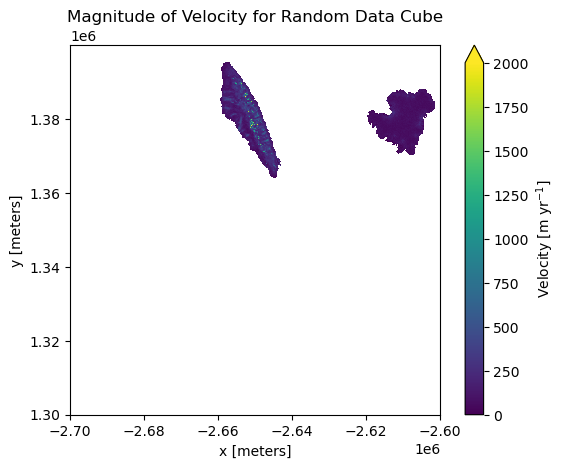

In [7]:
fig, ax = plt.subplots()

v = dc.v.mean(dim='mid_date').plot(ax=ax, vmax=2000)
v.colorbar.set_label('Velocity [m yr$^{-1}$]')
ax.set_aspect('equal')
ax.set_title('Magnitude of Velocity for Random Data Cube')
ax.set_xlabel('x [meters]')
ax.set_ylabel('y [meters]')
plt.show()

From a quick inspection of this plot, there appear to be two islands with a few faster flowing glaciers on the left one.

This is a sample of the temporal mean of velocity for this data cube over the complete timespan.

## Selecting Data Cubes by Point or Shape

I have written a function in `blue_ice_tools.py` that will grab the URLs for a corresponding point, list of points, or a shape passed through a GeoDataFrame. For this example, I will look at the Shirase Glacier in Antarctica.

In [8]:
bit.get_urls?

Signature:
bit.get_urls(
    shape: geopandas.geodataframe.GeoDataFrame = None,
    points: list | tuple = None,
    epsg: int = 3031,
) -> list
Docstring:
Retrieve URLs from the ITS_LIVE catalog that intersect with a given GeoDataFrame or set of points.

Parameters
----------
shape : gpd.GeoDataFrame, optional
    A GeoDataFrame specifying the region of interest in a given CRS.
points : list or tuple, optional
    A point (lon, lat) or a list of points [(lon, lat), (lon, lat), ...].
epsg : int, optional
    EPSG code used for filtering or projecting the GeoDataFrame. Default is 3031.

Returns
-------
list
    Unique ITS_LIVE data cube URLs intersecting the specified geometry or EPSG code.

Raises
------
TypeError
    If `epsg` is not an integer, or if inputs are not of expected types.
ValueError
    If the `shape` does not have a defined CRS, or `points` are not properly formatted.

Notes
-----
- If both `shape` and `points` are None, the function returns URLs filtered by the EPSG cod

The parameters of the function are the gdf or point(s) and the EPSG of the gdf or point(s). If you look closely, this function can run without any parameters being passed. 
- If you pass no parameters, it will return all of the Data Cube URLs for EPSG:3031
- If you only pass an EPSG, it will return all URLs for that projection
- If you specify a shape or point(s) not in EPSG:3031, make sure to specify which projection you are using

It provides multi-point functionality, which adds the ability to return all data cubes required to analyze a large area (such as a large glacier covering two or more data cubes)

If when using this function, you receive and error stating that 'index 0 is out of range', make sure your points as passed as (lon, lat), and are valid points that ITS_LIVE has data for in EPSG:4326

In [9]:
# Coordinates for the two data cubes on shirase
pts = ((39, -70), (39, -71))

# Shapefile loaded into GDF for shirase
shirase_outline = gpd.read_file('../data/shirase-glacier/shirase.shp')
shirase_outline

,OBJECTID,Id,area_km2,perim_km,geometry
0,20484,18637,1943.2,584.2,"POLYGON ((1363196.981 1723984.841, 1370628.789..."


In [10]:
pt_urls = bit.get_urls(points=pts)

shp_urls = bit.get_urls(shape=shirase_outline)

In [11]:
shp_urls == pt_urls

True

As can be seen with these two outputs, the URLs returned are the same, and the function can be used in either fashion to get the URLs for your area of interest.

Next, you can gather open the datasets on your own using `xr.open_dataset`, or you can use the function I created `bit.get_data_cube` to load in the data.

In [12]:
bit.get_data_cube?

Signature:
bit.get_data_cube(
    shape: geopandas.geodataframe.GeoDataFrame = None,
    urls: list | tuple | numpy.ndarray = None,
    epsg: int = 3031,
    dt_delta: int = None,
    engine: str = 'zarr',
) -> xarray.core.dataset.Dataset
Docstring:
Download and process ITS_LIVE velocity data cubes, optionally clipping them to a specified geometry.

Parameters
----------
shape : gpd.GeoDataFrame, optional
    GeoDataFrame defining the region of interest, with a defined CRS.
urls : list, tuple, or np.ndarray, optional
    URLs of ITS_LIVE data cubes. If not provided, `get_urls` is used with the `shape` and `epsg` parameters.
epsg : int, optional
    EPSG code for the CRS. Defaults to 3031.
dt_delta : int, optional
    Maximum allowed time difference (in days) for image pairs. Default is None (no filtering).
engine : str, optional
    Engine used for reading Zarr files. Defaults to 'zarr'.

Returns
-------
xr.Dataset
    Concatenated and resampled xarray Dataset representing the velocity

This function actually can call the `get_urls` function from before, but has a few more benefits.
- If any URLs are given, it will use those URLs to open the datasets. If no URLs are given, it will call `bit.get_urls` and open the dataset using `xr.open_mfdataset`.
- Only return the variables 'v', 'vx', 'vy'.
- Will return a timeseries of all mosaics where the time delta is less than the desired number of days
    - If you wanta different time delta, pass a different value for `dt_delta`
- If you pass a shapefile, it will also clip the dataset down to the shape using rioxarray.
- Resamples the dataset by month (every month to present).
- Rechunks the dask arrays for optimal parallelization.

Passing URLs and a shapefile are optional. If neither are passed, it will automatically call the get_urls function for the EPSG number and load in the data cubes that are in that region. 
- **This is HIGHLY advised against**
    - Pass at least URLs or a shapefile, as this will reduce the size of the datacube returned
    - If you want all of the data cubes from an EPSG number, this is the easiest way to get those

### URLs only

The following cells will show an example of using `get_bit.data_cube` by only passing URLs.

In [13]:
# Use pt_urls to load in datasets unclipped, plot v
url_dc = bit.get_data_cube(urls=pt_urls)
url_dc

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 21
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 21
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 21
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 21
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 21
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 21
  result = blockwise(


<xarray.Dataset> Size: 5GB
Dimensions:   (mid_date: 299, y: 1667, x: 833)
Coordinates:
  * x         (x) float64 7kB 1.3e+06 1.3e+06 1.3e+06 ... 1.4e+06 1.4e+06
  * y         (y) float64 13kB 1.6e+06 1.6e+06 1.6e+06 ... 1.8e+06 1.8e+06
  * mid_date  (mid_date) datetime64[ns] 2kB 1999-12-31 2000-01-31 ... 2024-10-31
Data variables:
    vx        (mid_date, y, x) float32 2GB dask.array<chunksize=(299, 312, 320), meta=np.ndarray>
    vy        (mid_date, y, x) float32 2GB dask.array<chunksize=(299, 312, 320), meta=np.ndarray>
    v         (mid_date, y, x) float32 2GB dask.array<chunksize=(299, 312, 320), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 13:16:09
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

There are three data variables, 'v', 'vx', and 'vy'. These are the velocity variables. The coordinates are 'x', 'y', and 'mid_date'. These are the x- and y-coordinate of the projection, which is in meters for this projection. 'mid_date' is the time that the image was taken, which after resampling is the last day of the month. The 'mid_date' dimension has a size of 97, the number of months since January 2015 that have data coverage (until January 2023).

Lets take a look at the velocities over this dataset

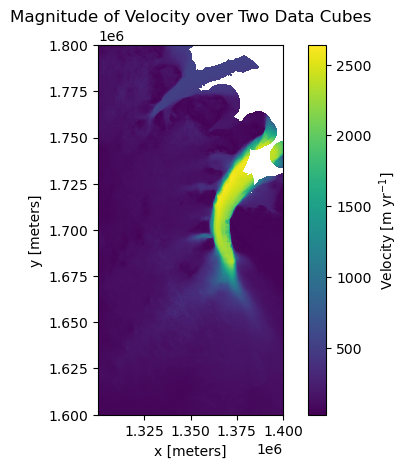

In [14]:
fig, ax = plt.subplots()

v = url_dc.v.mean(dim='mid_date').plot(ax=ax)
v.colorbar.set_label('Velocity [m yr$^{-1}$]')
ax.set_aspect('equal')
ax.set_title('Magnitude of Velocity over Two Data Cubes')
ax.set_xlabel('x [meters]')
ax.set_ylabel('y [meters]')
plt.show()

### URLs and a shapefile

Now, we will use a shapefile to cut down to the Shirase Glacier, which is the fast flowing portion on the middle-right of the map.

In [15]:
# Use shirase_outline shapefile and shp_urls to load in clipped ds, plot v
shp_dc = bit.get_data_cube(shape=shirase_outline, urls=pt_urls)
shp_dc

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


<xarray.Dataset> Size: 771MB
Dimensions:      (mid_date: 299, y: 655, x: 328)
Coordinates:
  * x            (x) float64 3kB 1.344e+06 1.344e+06 ... 1.383e+06 1.384e+06
  * y            (y) float64 5kB 1.649e+06 1.65e+06 ... 1.728e+06 1.728e+06
    spatial_ref  int64 8B 0
    mapping      int64 8B 0
  * mid_date     (mid_date) datetime64[ns] 2kB 1999-12-31 ... 2024-10-31
Data variables:
    vx           (mid_date, y, x) float32 257MB dask.array<chunksize=(299, 342, 328), meta=np.ndarray>
    vy           (mid_date, y, x) float32 257MB dask.array<chunksize=(299, 342, 328), meta=np.ndarray>
    v            (mid_date, y, x) float32 257MB dask.array<chunksize=(299, 342, 328), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 13:16:09
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

This dataset is MUCH smaller. If you compare the x- and y-dimension sizes, they're over half the size in each direction. This means much less data has been loaded in and is much easier on the memory.

Let's take a look at the temporal average of velocity over this region:

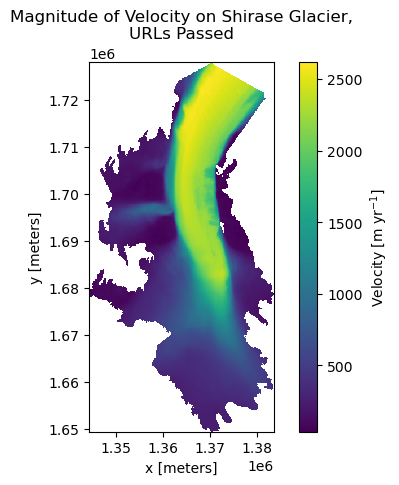

In [16]:
fig, ax = plt.subplots()

v = shp_dc.v.mean(dim='mid_date').plot(ax=ax)
v.colorbar.set_label('Velocity [m yr$^{-1}$]')
ax.set_aspect('equal')
ax.set_title('Magnitude of Velocity on Shirase Glacier,\nURLs Passed')
ax.set_xlabel('x [meters]')
ax.set_ylabel('y [meters]')
plt.show()

Here you can see the value of adding the shape parameter to `bit.get_data_cube`. It will clip the region down to the outline of the shapefile. <br>
Even though the URLs passed into the function are the same, the amount of data returned and plotted is vastly different.

### Shape Only

Next, we can see the value of the function being able to call `bit.get_urls` on its own. By only passing the outline of Shirase Glacier, we can produce the same exact plot. <br>
This allows us to save time and variables by only calling one function to produce a clipped data cube

In [17]:
# Use shirase_outline shapefile to load in clipped ds, plot v
shp_dc_2 = bit.get_data_cube(shape=shirase_outline)
shp_dc_2

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/core.py:4849: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


<xarray.Dataset> Size: 771MB
Dimensions:      (mid_date: 299, y: 655, x: 328)
Coordinates:
  * x            (x) float64 3kB 1.344e+06 1.344e+06 ... 1.383e+06 1.384e+06
  * y            (y) float64 5kB 1.649e+06 1.65e+06 ... 1.728e+06 1.728e+06
    spatial_ref  int64 8B 0
    mapping      int64 8B 0
  * mid_date     (mid_date) datetime64[ns] 2kB 1999-12-31 ... 2024-10-31
Data variables:
    vx           (mid_date, y, x) float32 257MB dask.array<chunksize=(299, 342, 328), meta=np.ndarray>
    vy           (mid_date, y, x) float32 257MB dask.array<chunksize=(299, 342, 328), meta=np.ndarray>
    v            (mid_date, y, x) float32 257MB dask.array<chunksize=(299, 342, 328), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 13:16:09
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

With one less parameter, and one less function call, we are able to produce the same sized dataset. 

Let's plot the velocity map to show this once and for all:

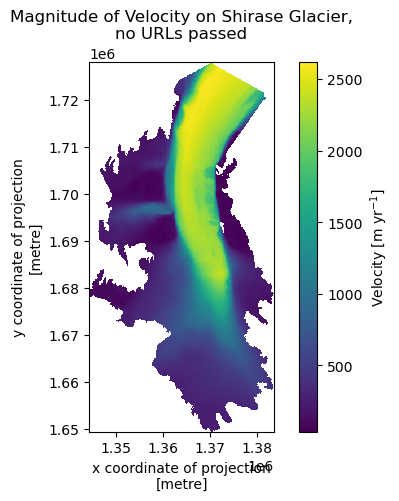

In [19]:
fig, ax = plt.subplots()
v = shp_dc_2.v.mean(dim='mid_date').plot(ax=ax)
v.colorbar.set_label('Velocity [m yr$^{-1}$]')
ax.set_aspect('equal')
ax.set_title('Magnitude of Velocity on Shirase Glacier,\nno URLs passed')
plt.show()

## Conclusion

Now you know how to load in ITS_LIVE cloud-hosted data and make simple velocity visualizations using the ITS_LIVE catalog and a few custom-built functions.

In the next notebook, we will work through how to derive strain rates using this velocity data. After that, we will look at analysis of these derived datasets on a monthly timescale.